In [81]:
import numpy as np
import os, PIL, random
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn')

import tensorflow as tf
print(f"Using Tensorflow {tf.__version__}")

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Using Tensorflow 2.4.1


In [82]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)
print(f"data_dir = {data_dir}")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

data_dir = /home/mjbhobe/.keras/datasets/flower_photos


In [83]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


The photos are organized as shown below:

`flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/`

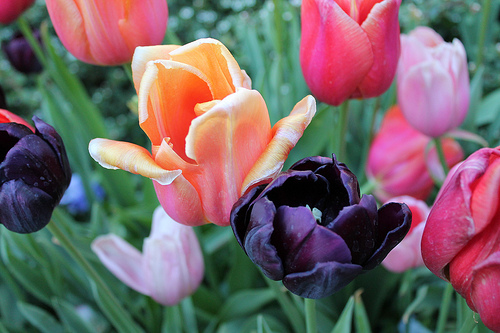

In [84]:
roses = list(data_dir.glob('*/*.jpg'))
rand_index = np.random.choice(np.arange(len(roses)),1)[0]
PIL.Image.open(str(roses[rand_index]))

In [85]:
batch_size = 32
image_height, image_width = 180, 180

In [86]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [87]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [88]:
class_names = train_ds.class_names
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

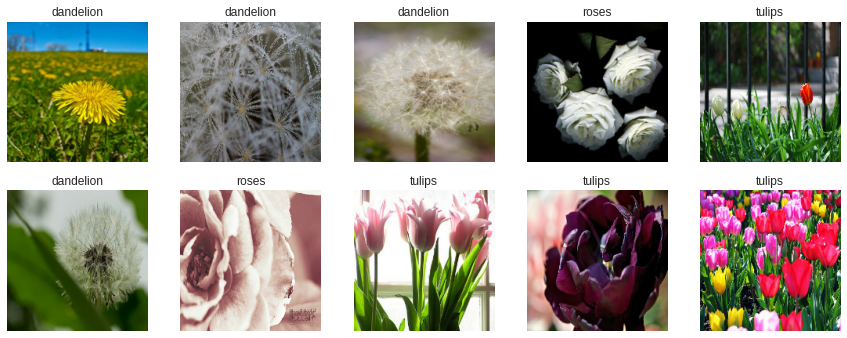

In [89]:
# visualize the data
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):  # will get batch_size images
  for i in range(10):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [90]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [91]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [92]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 22, 22, 64)       

In [93]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 118s 867ms/step - loss: 1.5098 - accuracy: 0.3686 - val_loss: 1.1250 - val_accuracy: 0.5354
Epoch 2/15
92/92 [==============================] - 78s 853ms/step - loss: 0.9838 - accuracy: 0.6251 - val_loss: 0.9337 - val_accuracy: 0.6362
Epoch 3/15
92/92 [==============================] - 85s 922ms/step - loss: 0.7589 - accuracy: 0.7070 - val_loss: 0.9083 - val_accuracy: 0.6485
Epoch 4/15
92/92 [==============================] - 85s 925ms/step - loss: 0.5040 - accuracy: 0.8288 - val_loss: 0.9374 - val_accuracy: 0.6662
Epoch 5/15
92/92 [==============================] - 86s 935ms/step - loss: 0.2835 - accuracy: 0.9007 - val_loss: 1.0376 - val_accuracy: 0.6567
Epoch 6/15
92/92 [==============================] - 85s 924ms/step - loss: 0.1463 - accuracy: 0.9533 - val_loss: 1.4559 - val_accuracy: 0.6308
Epoch 7/15
92/92 [==============================] - 85s 926ms/step - loss: 0.0825 - accuracy: 0.9756 - val_loss: 1.4389 - val_accuracy: 0.621

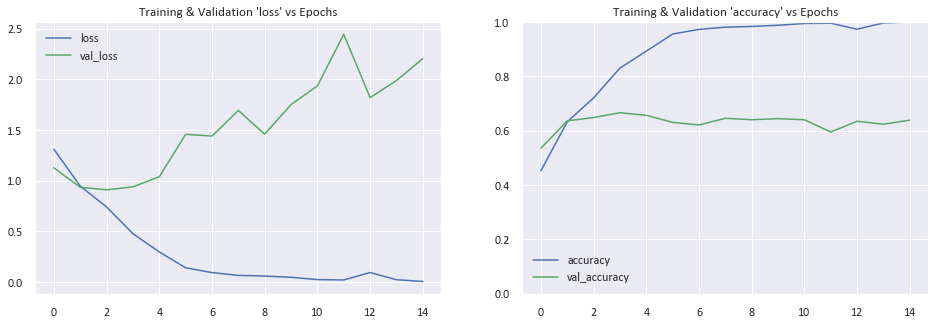

In [94]:
import kr_helper_funcs as kru

kru.show_plots(history.history, metric='accuracy')

In [95]:
loss, acc = model.evaluate(train_ds)
print(f"Training data  -> loss: {loss:.4f} - acc: {acc:.4f}")
loss, acc = model.evaluate(val_ds)
print(f"Cross-val data -> loss: {loss:.4f} - acc: {acc:.4f}")

92/92 [==============================] - 26s 285ms/step - loss: 0.0032 - accuracy: 0.9997
Training data  -> loss: 0.0032 - acc: 0.9997
23/23 [==============================] - 6s 272ms/step - loss: 2.2037 - accuracy: 0.6390
Cross-val data -> loss: 2.2037 - acc: 0.6390


In [96]:
kru.save_model(model, 'flowers', './model_states')

Saved model to file ./model_states/flowers.h5


In [97]:
model = kru.load_model('flowers')
print(model.summary())

Loaded Keras model from ./model_states/flowers.h5
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_

In [98]:
import cv2
from IPython import display
import PIL


def cv2_imload_asarray(image_path, image_size=None):
    """A replacement for cv2.imshow() for use in Jupyter notebooks.

    Args:
        a : np.ndarray. shape (N, M) or (N, M, 1) is an NxM grayscale image. shape
          (N, M, 3) is an NxM BGR color image. shape (N, M, 4) is an NxM BGRA color image.
    """
    a = cv2.imread(image_path)
    a = a.clip(0, 255).astype('uint8')
    if image_size is not None:
        a = cv2.resize(a, image_size)
    
    # cv2 stores colors as BGR; convert to RGB
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)

    img = PIL.Image.fromarray(a)
    image_array = keras.preprocessing.image.img_to_array(img)
    return img, image_array

/home/mjbhobe/.keras/datasets/test_rose2.jpg
(1, 180, 180, 3)
This image most likely belongs to roses with a 72.94 percent confidence.


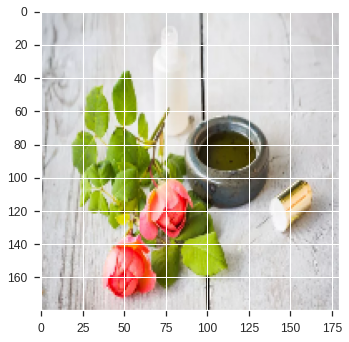

In [99]:
rose_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/d/db/Rosa_Peer_Gynt_1.jpg/1200px-Rosa_Peer_Gynt_1.jpg"
rose_url2 ="https://www.verywellhealth.com/thmb/4tcB_P528eyQJ9F79K7Jt-cjZ28=/700x0/filters:no_upscale():max_bytes(150000):strip_icc():format(webp)/GettyImages-530606660-587e5d215f9b584db303f32b.jpg"
rose_path = tf.keras.utils.get_file('test_rose2.jpg', origin=rose_url2)
print(f"{rose_path}")

# img = keras.preprocessing.image.load_img(rose_path, target_size=(image_height, image_width))
# img_array = keras.preprocessing.image.img_to_array(img)
# img_array = tf.expand_dims(img_array, 0) # Create a batch
img, img_array = cv2_imload_asarray(rose_path, image_size=(image_height, image_width))
img_array = tf.expand_dims(img_array, 0) # Create a batch
plt.imshow(img)
print(img_array.shape)

prediction = model.predict(img_array)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(prediction)], 100 * np.max(prediction))
)

In [100]:
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [101]:
poppy_url = "https://i.pinimg.com/736x/05/1e/88/051e887461c03c81457f12186d7c484f.jpg"
poppy_path = tf.keras.utils.get_file('poppy.jpg', origin=poppy_url)
print(f"{poppy_path}")

/home/mjbhobe/.keras/datasets/poppy.jpg


(1, 180, 180, 3)
This image most likely belongs to tulips with a 98.29 percent confidence.


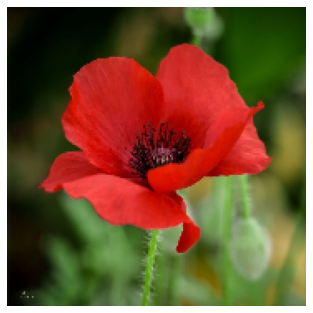

In [102]:
img, img_array = cv2_imload_asarray(poppy_path, image_size=(image_height, image_width))
img_array = tf.expand_dims(img_array, 0) # Create a batch
plt.imshow(img)
plt.axis('off')
print(img_array.shape)

prediction = model.predict(img_array)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(prediction)], 100 * np.max(prediction))
)

In [103]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(image_height,image_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

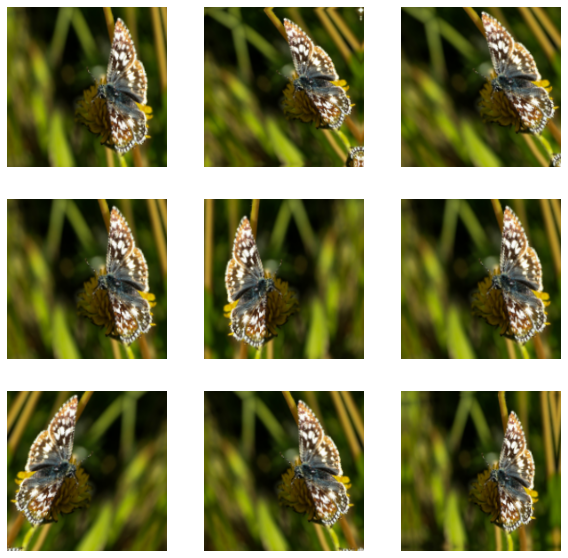

In [104]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [105]:
num_classes = 5

model2 = Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [106]:
epochs=25
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
92/92 [==============================] - 102s 1s/step - loss: 1.5277 - accuracy: 0.3501 - val_loss: 1.3399 - val_accuracy: 0.4768
Epoch 2/25
92/92 [==============================] - 98s 1s/step - loss: 1.0343 - accuracy: 0.5909 - val_loss: 0.9305 - val_accuracy: 0.6458
Epoch 3/25
92/92 [==============================] - 126s 1s/step - loss: 0.9040 - accuracy: 0.6534 - val_loss: 0.8884 - val_accuracy: 0.6621
Epoch 4/25
92/92 [==============================] - 102s 1s/step - loss: 0.8803 - accuracy: 0.6657 - val_loss: 0.8630 - val_accuracy: 0.6649
Epoch 5/25
92/92 [==============================] - 105s 1s/step - loss: 0.7763 - accuracy: 0.6994 - val_loss: 0.7995 - val_accuracy: 0.6839
Epoch 6/25
92/92 [==============================] - 100s 1s/step - loss: 0.7095 - accuracy: 0.7315 - val_loss: 0.8389 - val_accuracy: 0.6703
Epoch 7/25
92/92 [==============================] - 110s 1s/step - loss: 0.7111 - accuracy: 0.7268 - val_loss: 0.7551 - val_accuracy: 0.7044
Epoch 8/25
92/

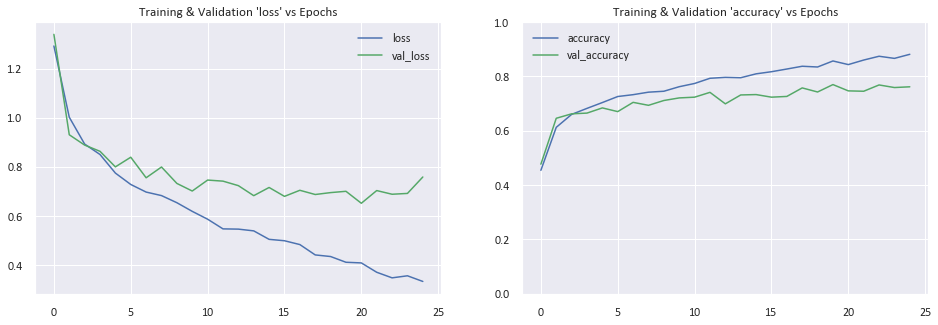

In [107]:
import kr_helper_funcs as kru

kru.show_plots(history.history, metric='accuracy')

In [108]:
loss, acc = model2.evaluate(train_ds)
print(f"Training data  -> loss: {loss:.4f} - acc: {acc:.4f}")
loss, acc = model2.evaluate(val_ds)
print(f"Cross-val data -> loss: {loss:.4f} - acc: {acc:.4f}")

92/92 [==============================] - 24s 265ms/step - loss: 0.3319 - accuracy: 0.8798
Training data  -> loss: 0.3319 - acc: 0.8798
23/23 [==============================] - 7s 285ms/step - loss: 0.7583 - accuracy: 0.7616
Cross-val data -> loss: 0.7583 - acc: 0.7616


In [109]:
kru.save_model(model2, 'flowers2', './model_states')
del model2

Saved model to file ./model_states/flowers2.h5


In [110]:
model2 = kru.load_model('flowers2')
print(model2.summary())

Loaded Keras model from ./model_states/flowers2.h5
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
con

/home/mjbhobe/.keras/datasets/test_rose2.jpg
(1, 180, 180, 3)
This image most likely belongs to roses with a 72.94 percent confidence.


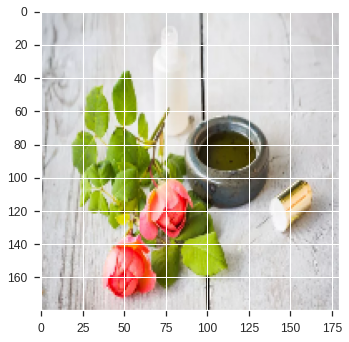

In [111]:
rose_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/d/db/Rosa_Peer_Gynt_1.jpg/1200px-Rosa_Peer_Gynt_1.jpg"
rose_url2 ="https://www.verywellhealth.com/thmb/4tcB_P528eyQJ9F79K7Jt-cjZ28=/700x0/filters:no_upscale():max_bytes(150000):strip_icc():format(webp)/GettyImages-530606660-587e5d215f9b584db303f32b.jpg"
rose_path = tf.keras.utils.get_file('test_rose2.jpg', origin=rose_url2)
print(f"{rose_path}")

# img = keras.preprocessing.image.load_img(rose_path, target_size=(image_height, image_width))
# img_array = keras.preprocessing.image.img_to_array(img)
# img_array = tf.expand_dims(img_array, 0) # Create a batch
img, img_array = cv2_imload_asarray(rose_path, image_size=(image_height, image_width))
img_array = tf.expand_dims(img_array, 0) # Create a batch
plt.imshow(img)
print(img_array.shape)

prediction = model.predict(img_array)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(prediction)], 100 * np.max(prediction))
)